In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the train and test datasets
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
# Separate features and target for train and validation data

X_train = df_train.drop(["id", "yield"], axis=1)
y_train = df_train["yield"]

X_test = df_test.drop(["id"], axis=1)

In [4]:
def evaluate_model(model, X, y, n_splits=5):
    """
    Evaluates the given model using cross-validation and calculates the Mean Absolute Errors.

    Parameters:
    -----------
    model (estimator object): The model to be evaluated.
    X (DataFrame): The feature matrix.
    y (Series): The target variable.
    selected_features (Index): The selected feature names.
    n_splits (int): The number of folds for cross-validation.

    Returns:
    --------
    mae_scores (list): A list of MAE for each fold.
    """
    # Initialize a list to store the MAE
    mae_scores = []

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=5)

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into train and test sets for the current fold
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training data
        model.fit(X_train_cv, y_train_cv)

        # Predict probabilities for the test (keep only the probability of the positive class)
        y_pred = model.predict(X_test_cv)

        # Calculate the MAE for the current fold
        mae = mean_absolute_error(y_test_cv, y_pred)
        mae_scores.append(mae)

    # Return the MAE, rounded to 5 decimal places
    return [round(value, 3) for value in mae_scores]

In [5]:
# Initialize the models

models = {
    "Lasso": Lasso(),
    "LightGBM": lgb.LGBMRegressor(random_state=5),
    "RandomForest": RandomForestRegressor(random_state=5),
    "CatBoost": CatBoostRegressor(silent=True, random_seed=5),
    "SVR": SVR(),
}

Model: Lasso
MAE Scores: [380.239, 388.318, 381.955, 376.453, 372.716]
Average MAE: 379.936
Std Deviation: 5.267

Model: LightGBM
MAE Scores: [350.234, 363.772, 354.28, 356.205, 349.497]
Average MAE: 354.798
Std Deviation: 5.132

Model: RandomForest
MAE Scores: [364.23, 372.959, 366.691, 370.263, 365.005]
Average MAE: 367.830
Std Deviation: 3.300

Model: CatBoost
MAE Scores: [348.302, 365.732, 355.04, 358.987, 353.197]
Average MAE: 356.252
Std Deviation: 5.854

Model: SVR
MAE Scores: [1018.568, 1025.959, 1021.869, 1028.88, 1020.611]
Average MAE: 1023.177
Std Deviation: 3.736



<Figure size 720x504 with 0 Axes>

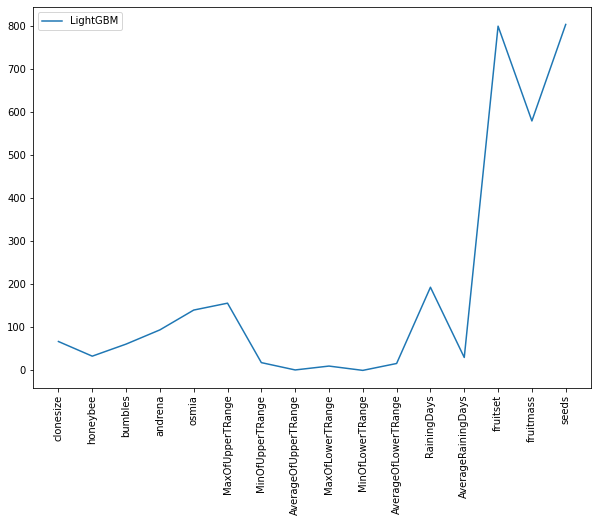

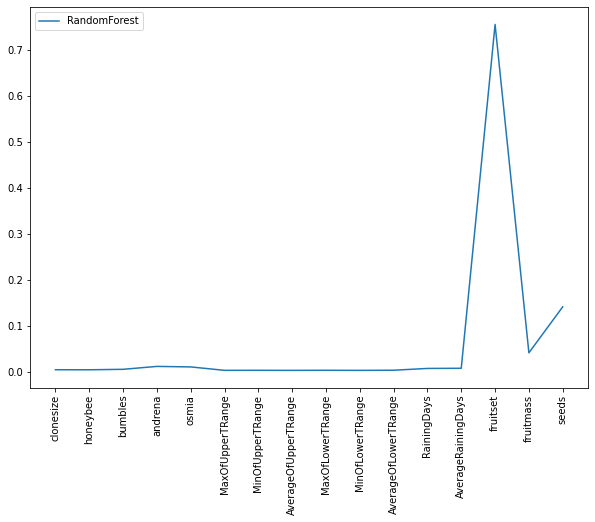

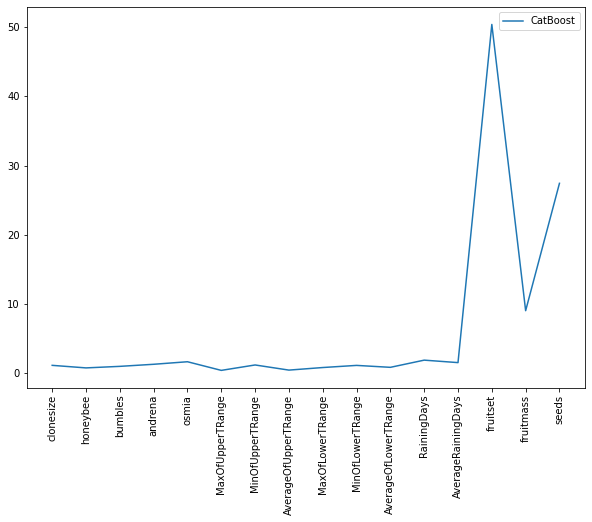

<Figure size 720x504 with 0 Axes>

In [6]:
# Evaluate each model using the best subset of features
for name, model in models.items():
    """
    Loops through each model, and evaluates the model using cross-validation. 
    Prints the MAE scores, average MAE, and standard deviation
    for each model.
    """
    # Evaluate the model using cross-validation with the selected features
    mae_scores = evaluate_model(model, X_train, y_train)
    mean_mae = np.mean(mae_scores)
    std = np.std(mae_scores)

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predict for the test set
    y_test_pred = model.predict(X_test)

    df_test["yield"] = y_test_pred.round(3)

    # Save the output DataFrame to a CSV file
    df_test[["id", "yield"]].to_csv(f"submission_{name}.csv", index=False)

    # Print the results for the current model
    print(f"Model: {name}")
    print(f"MAE Scores: {mae_scores}")
    print(f"Average MAE: {mean_mae:.3f}")
    print(f"Std Deviation: {std:.3f}")

    try:
        plt.figure(figsize=(10, 7))
        plt.plot(model.feature_importances_, label=name)
        plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)
        plt.legend()
    
    except AttributeError: # Incase the model does not have "feature_importances_"
        pass
    
    print()